In [2]:
import scipy.io
import scipy.stats
import math
mat = scipy.io.loadmat('E:/data/2Dparticle.mat')


In [245]:
print(mat['XTRUE'][2])


[ 2.72704234e-04  8.18091935e-04  1.63612157e-03  2.72673084e-03
  4.08983670e-03  5.72533533e-03  7.63310219e-03  9.81299199e-03
  1.22648387e-02  1.49884557e-02  1.79836355e-02  2.12501499e-02
  2.47877504e-02  2.85961674e-02  3.26751109e-02  3.70242703e-02
  4.16433144e-02  4.65318914e-02  5.16896291e-02  5.71161346e-02
  6.28109948e-02  6.87737759e-02  7.50040239e-02  8.15012642e-02
  8.82650021e-02  9.52947226e-02  1.02589890e-01  1.10149949e-01
  1.17974325e-01  1.26062420e-01  1.34413619e-01  1.43027286e-01
  1.51902766e-01  1.61039382e-01  1.70436438e-01  1.80093219e-01
  1.90008989e-01  2.00182994e-01  2.10614459e-01  2.21302588e-01
  2.32246569e-01  2.43445567e-01  2.54898731e-01  2.66605187e-01
  2.78564044e-01  2.90774392e-01  3.03235300e-01  3.15945820e-01
  3.28904984e-01  3.42111805e-01  3.55565276e-01  3.69264375e-01
  3.83208056e-01  3.97395260e-01  4.11824904e-01  4.26495890e-01
  4.41407101e-01  4.56557402e-01  4.71945638e-01  4.87570638e-01
  5.03195638e-01  5.18820

In [246]:
print(mat['Z'].T[100].T[0:2].T)



[[nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]]


In [247]:
import numpy as np

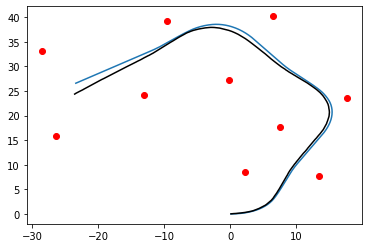

In [248]:
lm=mat['lm']
xodo=mat['XODO']
import matplotlib.pyplot as plt
plt.plot(lm[0],lm[1],'ro')
xtrue=mat['XTRUE']
plt.plot(xtrue[0],xtrue[1])
plt.plot(xodo[0],xodo[1],color='black')

In [249]:
### tạo particle 
def particle(vtrue,delta_v,gtrue,delta_g,x0,y0,gamma,N):
    v=np.random.normal(vtrue,delta_v,N)
    g=np.random.normal(gtrue,delta_g,N)
    x=x0+v*0.025*np.cos(g)
    y=y0+v*0.025*np.sin(g)
    gamma=gamma+g
    return x,y,gamma

In [250]:
def tinhkhoangcach(particle,measu_3,lm):
    mean = np.zeros((5,2))
    for i in range(5):
        if math.isnan(measu_3[i]):
            return mean
        else:
            zx = particle[0]-lm[(measu_3[i]-1).astype(int)][0]
            zy = particle[1]-lm[(measu_3[i]-1).astype(int)][1]
            z = np.sqrt(zx*zx+zy*zy)
            alpha = np.arctan(zy/zx)
            if zy > 0 and zx < 0:
                alpha = 180+alpha
            if zy < 0 and zx < 0:
                alpha = alpha - 180
            beering = alpha - particle[2]
            mean[i] = (z,beering)
    return mean
            
        
        
def weight(mean,dolech, measu_12):
    ### mean array 3 so
    ##do lech too
    sum_w = 0
    so_landmark = 0
    for i in range(5):
        so_landmark = i+1
        if math.isnan(measu_12[i][0]):
            if i == 0:
                return 1
            else:
                break
        else:
            sum_w += scipy.stats.norm.pdf((measu_12[i][0]-0.1,measu_12[i][0]+0.1),mean[i][0],dolech[0])
            sum_w += scipy.stats.norm.pdf((measu_12[i][1]-0.01,measu_12[i][1]+0.01),mean[i][1],dolech[1])
    return sum_w/so_landmark

ValueError: probabilities do not sum to 1

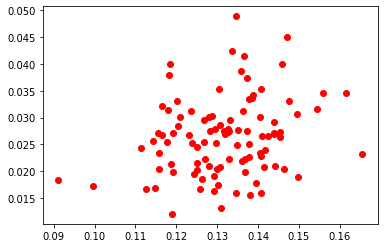

In [251]:
import numpy as np
N=625
Xtrue = mat['XTRUE']
XTrue_tinh_duoc_max = []
XTrue_tinh_duoc_tb = []
XTrue_tinh_duoc_min = []
XODO = mat['XODO']
vg=mat['VG']
x_pre=np.zeros((3,N))

for i in range(N):
    x_pre[0][i]=XODO[0][i]-np.cos(XODO[2][i])*vg[0][i]*0.025  ## hoanh do
    x_pre[1][i]=XODO[1][i]-np.sin(XODO[2][i])*vg[0][i]*0.025## tung do
    x_pre[2][i]=XODO[2][i]-vg[1][i]
    
    ## PARTICLE 
    M=100 # sample
    w = [] ##trong so cua particle
    x,y,gamma=particle(vg[0][0],0.5,vg[1][0],np.pi/60,x_pre[0][0],x_pre[1][0],x_pre[2][0],M)
    plt.plot(x,y,'ro')
    for j in range(M):
        khoangcach_goclech = tinhkhoangcach((x[j],y[j],gamma[j]),mat['Z'].T[i].T[2],lm.T)
        w.append(weight(khoangcach_goclech,(0.025,np.pi/60),mat['Z'].T[i].T[0:2].T))
   
    w = np.array(w)
    sum_w = np.sum(w)
    for i  in range(M):
        w[i] = w[i]/sum_w
    ##lay mau lan nua
    X = [] ##day la M particle cuoi cung
    id = np.zeros(M).astype(int)
    for j in range(M):
        id[j] = j
    id = np.random.choice(id, M, p=w)
    for j in range(M):
        X.append((x[id[j]],y[id[j]],gamma[id[j]],w[id[j]]))
    ##tinh particle co trong so lon nhat, nho nhat, va trung binh
    X = np.array(X)
    XTrue_tinh_duoc_max.append(X[np.argmax(X.T[3])][0:3])
    XTrue_tinh_duoc_min.append(X[np.argmin(X.T[3])][0:3])
    ## tinh particle trung binh
    x_tb = np.sum(X.T[0]*X.T[3])
    y_tb = np.sum(X.T[1]*X.T[3])
    gamma_tb = np.sum(X.T[2]*X.T[3])
    XTrue_tinh_duoc_tb.append((x_tb,y_tb,gamma_tb))



In [ ]:
print(XTrue_tinh_duoc_tb)

In [ ]:
a=np.random.randint(1,5,(5,4))
print(a.shape)
b=a.reshape(1,5)
print(b.reshape((5,)))

In [ ]:
print(np.zeros(10).astype(int))

In [252]:
print(w)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
